<a href="https://colab.research.google.com/github/farfaness/test/blob/master/Lesson1_pets_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64 #HOW MANY images do you train AT ONE TIME?
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [0]:
help(untar_data) #function to download and extract data from an url
# the : indicates the types
#Union mean : or

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [0]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [0]:
path = untar_data(URLs.PETS); path #download to convenient path, untar it, and return the value of path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path.ls() # ls method to path, to see what is in the path

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
path_anno.ls()[:]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/README'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt')]

In [0]:
path_img.ls()[0:3]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_169.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_112.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_57.jpg')]

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [0]:
fnames = get_image_files(path_img) #grab an array of all of the image files based on extension in a path
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_169.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_112.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_57.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_168.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_208.jpg')]

In [0]:
len(fnames)

7390

In [0]:
np.random.seed(2) #fix the random seed
pat = r'/([^/]+)_\d+.jpg$' #regex expression to get pictures labels

 An ImageDataBunch represents all of the data you need to build a model and there’s some factory method to create that data bunch - a training set, a validation set with images and labels.

-> In this case, we need to extract the labels from the names. We are going to use from_name_re.re (module in Python for regular expressions)

In [0]:
help(ImageDataBunch)

Help on class ImageDataBunch in module fastai.vision.data:

class ImageDataBunch(fastai.basic_data.DataBunch)
 |  DataBunch suitable for computer vision.
 |  
 |  Method resolution order:
 |      ImageDataBunch
 |      fastai.basic_data.DataBunch
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  batch_stats(self, funcs:Collection[Callable]=None, ds_type:fastai.basic_data.DatasetType=<DatasetType.Train: 1>) -> torch.Tensor
 |      Grab a batch of data and call reduction function `func` per channel
 |  
 |  normalize(self, stats:Collection[torch.Tensor]=None, do_x:bool=True, do_y:bool=False) -> None
 |      Add normalize transform using `stats` (defaults to `DataBunch.batch_stats`)
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  create_from_ll(lls:fastai.data_block.LabelLists, bs:int=64, val_bs:int=None, ds_tfms:Union[Callable, Collection[Callable], NoneType]=None, num_workers:int=2, dl_tfms:Union[Coll

In [0]:
# Imagedatabunch is a subclass of the object class databunch
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

# From name re : To get the target label from the filename with regex expression

# Get transforms :  transform the images in size 224, 
# the models are designed so that the final layer is of size 7 by 7, 
# so we actually want something where if you go 7 times 2 a bunch of times (224 = 7*2^5), 
# then you end up with something that’s a good size

# Normalize the images using imagenet_stats, to have RGB channels with same mean and same std

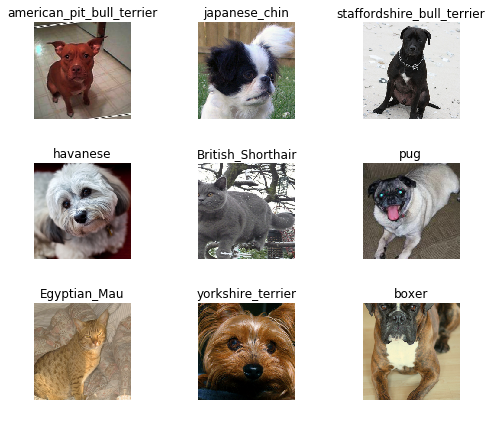

In [0]:
data.show_batch(rows=3, figsize=(7,6)) #to see the content of our data bunch

In [0]:
print(data.classes)
len(data.classes),data.c #C is the number of classes

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

In [0]:
data.c

37

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

 A model is trained in fastai using something called a “learner”.


In [0]:
help(cnn_learner)

Help on function cnn_learner in module fastai.vision.learner:

cnn_learner(data:fastai.basic_data.DataBunch, base_arch:Callable, cut:Union[int, Callable]=None, pretrained:bool=True, lin_ftrs:Union[Collection[int], NoneType]=None, ps:Union[float, Collection[float]]=0.5, custom_head:Union[torch.nn.modules.module.Module, NoneType]=None, split_on:Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType]=None, bn_final:bool=False, init=<function kaiming_normal_ at 0x7f2714e2be18>, concat_pool:bool=True, **kwargs:Any) -> fastai.basic_train.Learner
    Build convnet style learner.



In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate) #convolutionnal network

# base_arch : architecture ResNet34 ou Resnet50 pre-trained weights
# download pretrained weights resnet model on more than one million imagenet 
# (peut reconnaitre environ 1000 types de catégories d'imagenet)

#dans le data bunch a validation set a été automatiquement créer, la metrics sera testée dessus

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 46124872.16it/s]


 This particular model has actually already been trained for a particular task. And that particular task is that it was trained on looking at about **one and a half million pictures** of all kinds of different things, a **thousand categories of things**, **using an image dataset called ImageNet**. So we can download those pre-trained weights so that we don’t start with a model that knows nothing about anything, but we actually start with a model that knows how to recognize a thousand categories of things in ImageNet. I don’t think all of these 37 categories of pet are in ImageNet but there were certainly some kinds of dog and some kinds of cat. So this pre-trained model knows quite a little bit about what pets look like, and it certainly knows quite a lot about what animals look like and what photos look like. So the idea is that we don’t start with a model that knows nothing at all, but we start by downloading a model that knows something about recognizing images already. So it downloads for us automatically, the first time we use it, a pre-trained model and then from now on, it won’t need to download it again - it’ll just use the one we’ve got.

 It is “transfer learning.” How to take a model that already knows how to do something pretty well and make it so that it can do your thing really well. We will take a pre-trained model, and then we fit it so that instead of predicting a thousand categories of ImageNet with ImageNet data, it predicts the 37 categories of pets using your pet data. By doing this, you can train models in 1/100 or less of the time of regular model training with 1/100 or less of the data of regular model training. Potentially, many thousands of times less. Remember I showed you the slide of Nikhil’s lesson 1 project from last year? He used 30 images. There are not cricket and baseball images in ImageNet but it turns out that ImageNet is already so good at recognizing things in the world that just 30 examples of people playing baseball and cricket was enough to build a nearly perfect classifier. 

In [0]:
learn.model #infos on the learner model used

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.fit_one_cycle(4) #nbr de cycles ou epochs sur toutes nos données

#the error rate is computed on a validation set created by the image data bunch 
#and never seen by the learner to avoid overfitting

epoch,train_loss,valid_loss,error_rate,time
0,1.373000,0.332937,0.106225,01:44
1,0.564376,0.233670,0.075101,01:45
2,0.347926,0.210791,0.073748,01:44
3,0.258642,0.204302,0.074425,01:44


In [0]:
learn.save('stage-1')

## Results

 Remember a learn object knows two things: 1. What’s your data 2. What is your model. Now it’s not just an architecture, it’s actually a trained model


Which were the categories that the model most confused with one another?

See if what the model predicted was reasonable or not? In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

 A loss function is something that tells you how good was your prediction. Specifically that means if you predicted one class of cat with great confidence, but actually you were wrong, then that’s going to have a high loss because you were very confident about the wrong answer. So that’s what it basically means to have high loss. By plotting the top losses, we are going to find out what were the things that we were the most wrong on, or the most confident about what we got wrong

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

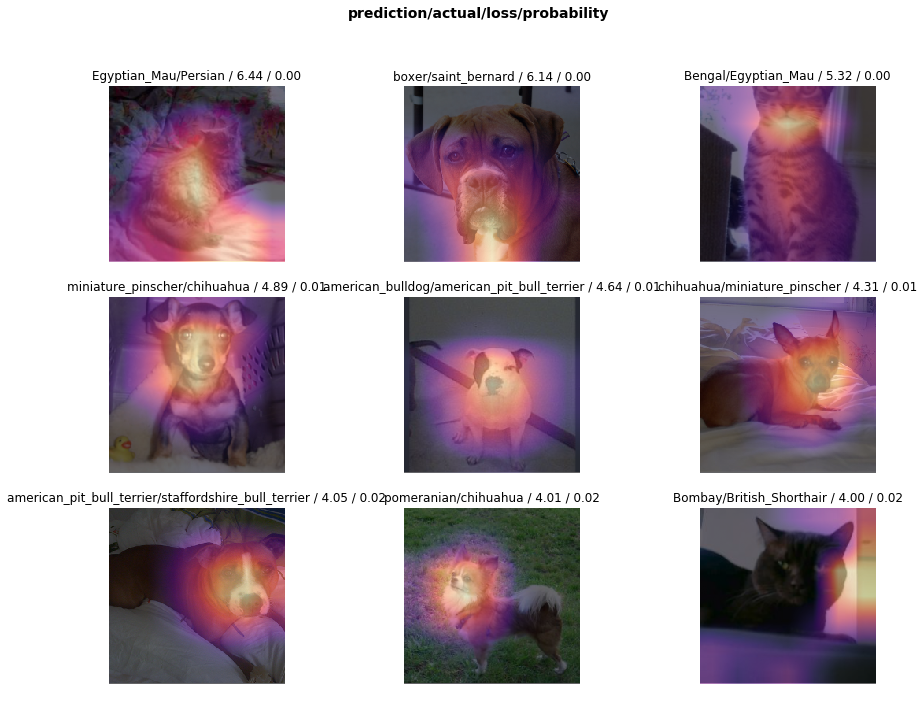

In [0]:
interp.plot_top_losses(9, figsize=(15,11)) #show prediction/reality/loss/probability of the actual class

In [0]:
doc(interp.plot_top_losses)

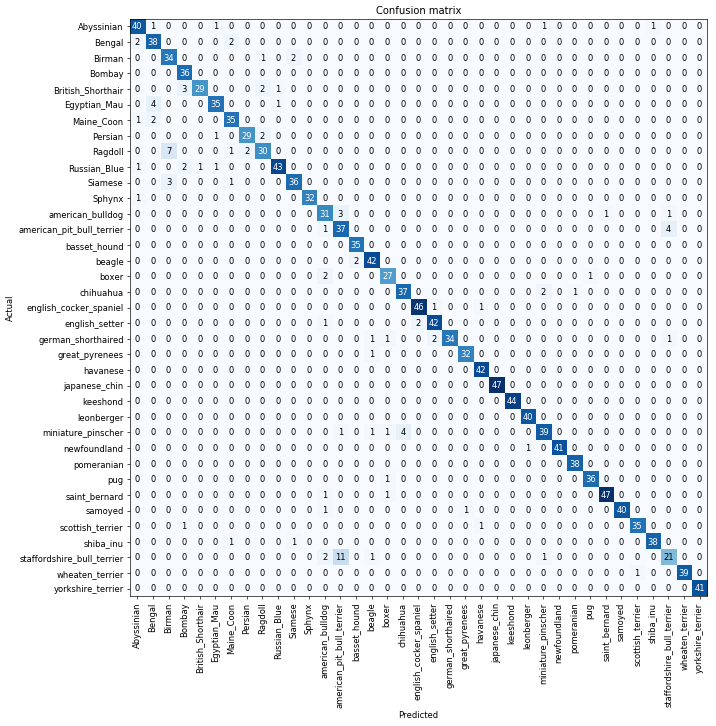

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2) #show the pairs that were the wrong le plus souvent

#predicted/actuel/nbr of mistakes

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 11),
 ('Ragdoll', 'Birman', 7),
 ('Egyptian_Mau', 'Bengal', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('miniature_pinscher', 'chihuahua', 4),
 ('British_Shorthair', 'Bombay', 3),
 ('Siamese', 'Birman', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'Maine_Coon', 2),
 ('Birman', 'Siamese', 2),
 ('British_Shorthair', 'Ragdoll', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Persian', 'Ragdoll', 2),
 ('Ragdoll', 'Persian', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('beagle', 'basset_hound', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('german_shorthaired', 'english_setter', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

## Unfreezing, fine-tuning, and learning rates

So when we first trained (i.e.fine-tuned) the pre-trained model, we kept all of the layers of the model and we just trained a few more layers on top of all of those sophisticated features that are already being created (step 1). So now by unfreezing we are going back and saying “let’s change all of these" (step 2) 

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze() #to train the whole model and not just the lasts layers of a pretrained model

#different layers represent different levels of semantic complexity, 
#from finding diagonal pattern to finding dog faces

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.518595,0.324871,0.100812,01:55


Now, it seems very unlikely that we can make layer 1 features better. It’s very unlikely that the definition of a diagonal line is going to be different when we look at dog and cat breeds versus the ImageNet data that this was originally trained on. So we don’t really want to change the layer 1 very much if at all. Or else, the last layers, like types of dog face seems very likely that we do want to change that. 

This is why our attempt to fine-tune this model didn’t work because by default, it trains all the layers at the same speed which is to say it will update those things representing diagonal lines and gradients just as much as it tries to update the things that represent the exact specifics of what an eyeball looks like, so we have to change that.

To change it, we first of all need to go back to where we were before. 

In [0]:
learn.load('stage-1'); #model as he was before unfreezing

In [0]:
learn.lr_find() #learning rate finder, what is the fastest I can train this neural network at ?
#learning rate : how quickly I am updating the parameters of my model?

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


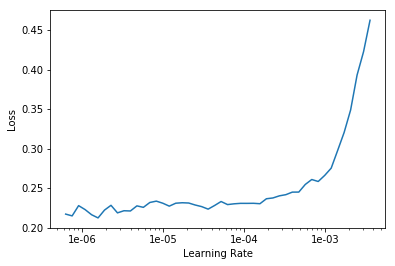

In [0]:
learn.recorder.plot() #plot the result of the LR finder
#what happened when I increase the learning rate?

 The x-axis one here shows me what happens as I increase the learning rate. The y axis show what the loss is. So you can see, once the learning rate gets passed 10^-4, my loss gets worse. It actually so happens, in fact I can check this if I press shift+tabhere, my learning defaults to 0.003. So you can see why our loss got worse. Because we are trying to fine-tune things now, we can’t use such a high learning rate. So based on the learning rate finder, I tried to pick something well before it started getting worse. So I decided to pick1e-6. But there’s no point training all the layers at that rate, because we know that the later layers worked just fine before when we were training much more quickly. 

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4)) #train first layer at 1e-6 and the last ones at 1e-4 
#(because we now that these last layers are already working well with default value of 1e-3, so there no need to train them slower)

#regle après unfreeze : on met 10 fois plus rapide que moment où devient pas bon d'après le LR finder pour première couches, 
#et environ 10 fois plus rapide que valeur de défault (ici c'était 1e-3) pour les dernières couches

epoch,train_loss,valid_loss,error_rate,time
0,0.230609,0.194330,0.069012,01:50
1,0.202405,0.193997,0.066982,01:50


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats) #Reduce batch size if it run out of GPU memory

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 52072335.11it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


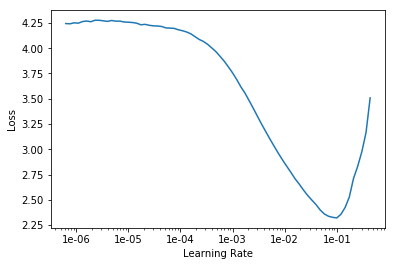

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8) 

epoch,train_loss,valid_loss,error_rate,time
0,1.133803,0.288654,0.084574,03:20
1,0.476679,0.231412,0.079161,03:17
2,0.317033,0.220051,0.067659,03:16
3,0.231274,0.177474,0.063599,03:13
4,0.152628,0.165648,0.056157,03:14
5,0.132978,0.162100,0.052097,03:14
6,0.096251,0.159326,0.050744,03:14
7,0.078231,0.157971,0.050744,03:14


In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.069086,0.158878,0.048714,04:10
1,0.071381,0.147027,0.046685,04:05
2,0.061694,0.144688,0.046685,04:04


If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

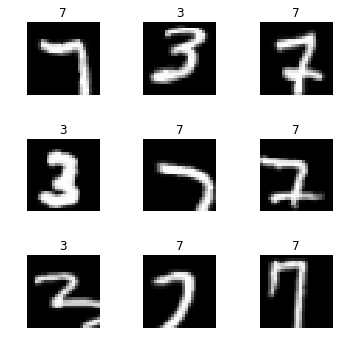

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

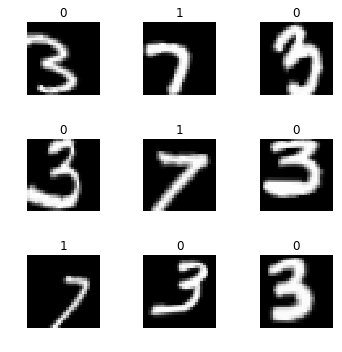

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']